# ML - Fall 2023 - Practical 5

## Decision Trees

Student Name: Amirhossein Alamdar

Student Number: 400105144

In [1]:
! pip install optuna
! pip install catboost
! pip install gdown

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
!gdown 'https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr'

Downloading...
From: https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr
To: /kaggle/working/train.csv
100%|█████████████████████████████████████████| 170k/170k [00:00<00:00, 103MB/s]


# P1: Explore (13 points)

Load the dataset as a dataframe 

In [4]:
df = pd.read_csv('train.csv')

Inspect the first rows of the dataframe **(P1-1: 1 point)**

In [5]:
df.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,...,2,80,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1,1585,...,1,80,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1,1478,...,4,80,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1,1965,...,1,80,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,1,722,...,4,80,0,10,2,2,10,7,0,8
5,50,No,Travel_Frequently,1234,Research & Development,20,5,Medical,1,1606,...,3,80,1,32,3,3,30,8,12,13
6,30,No,Travel_Rarely,852,Sales,10,3,Marketing,1,1179,...,1,80,1,10,3,3,10,3,1,4
7,21,Yes,Travel_Rarely,156,Sales,12,3,Life Sciences,1,494,...,4,80,0,1,0,3,1,0,0,0
8,26,No,Travel_Rarely,1443,Sales,23,3,Marketing,1,72,...,3,80,1,5,2,2,2,2,0,0
9,27,No,Travel_Rarely,269,Research & Development,5,1,Technical Degree,1,844,...,2,80,1,9,3,3,9,8,0,8


Calculate the number of samples **(P1-2: 0.5 point)**

In [6]:
n_samples = len(df)
n_samples

1102

Measure the number of unique values for each column. Note that `Attrition` is the target column. **(P1-3: 1.5 points)**

In [7]:
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    736
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1102
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1027
MonthlyRate                 1082
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

Check if there is a column with less than two unique values. If such a columns exists, remove it! **(P1-4: 1.5 points)**

In [8]:
df = df.drop(columns=df.columns[df.nunique() < 2])
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1883,4,...,3,2,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1585,2,...,3,1,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1478,4,...,3,4,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1965,4,...,3,1,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,722,4,...,3,4,0,10,2,2,10,7,0,8


Plot Mean `BusinessTravel` against `Age`. Note: Since the `BusinessTravel` column is categorical, you should first consider another column corresponding to each unique value `BusinessTravel` takes. For instance, you may assume that if someone does not travel, the value of the column for this person is 0. **(P1-5: 2.5 points)**

In [9]:
df['BusinessTravel_numeric'] = df['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})

In [10]:
grouped_data = df.groupby('Age')['BusinessTravel_numeric'].mean()
grouped_data2 = df.groupby('BusinessTravel_numeric')['Age'].mean()

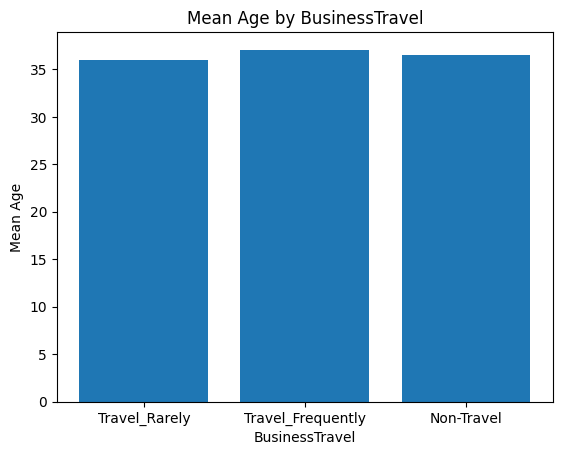

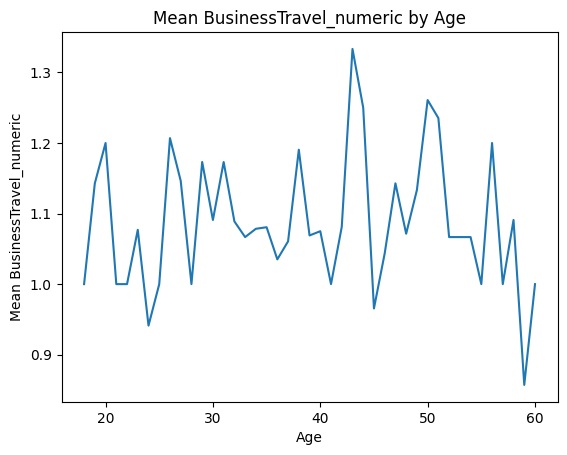

In [11]:
# Plot the mean BusinessTravel against Age
plt.bar(grouped_data2.index,grouped_data2)
plt.xlabel('BusinessTravel')
plt.ylabel('Mean Age')
plt.xticks(ticks=grouped_data2.index, labels=df['BusinessTravel'].unique())
plt.title('Mean Age by BusinessTravel')
plt.show()

plt.plot(grouped_data.index, grouped_data)
plt.xlabel('Age')
plt.ylabel('Mean BusinessTravel_numeric')
plt.title('Mean BusinessTravel_numeric by Age')
plt.show()

Find the `Department` in which the least amount of time has passed since the last promotion of the employees on average. **(P1-6: 1 point)**

In [12]:
per_department = df.groupby('Department')['YearsSinceLastPromotion'].mean()
min_indices = per_department.idxmin()
min_indices

'Human Resources'

Check if there seems to be a meaningful relationship between people's age and the years they have worked with their current manager. Your result should be a plot. **(P1-7: 2 points)**

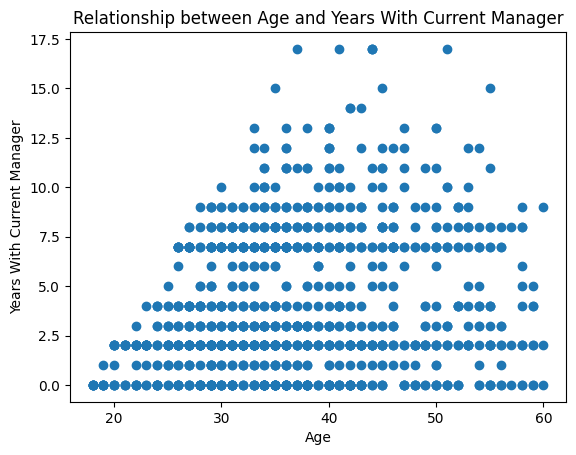

In [13]:
plt.scatter(df['Age'], df['YearsWithCurrManager'])
plt.xlabel('Age')
plt.ylabel('Years With Current Manager')
plt.title('Relationship between Age and Years With Current Manager')
plt.show()

Compare the average `JobSatisfaction` for employees whose `JobRole` is `Research Scientist`, `Human Resources`, `Manager`, or `Research Director` using a plot.  **(P1-8: 2 points)**

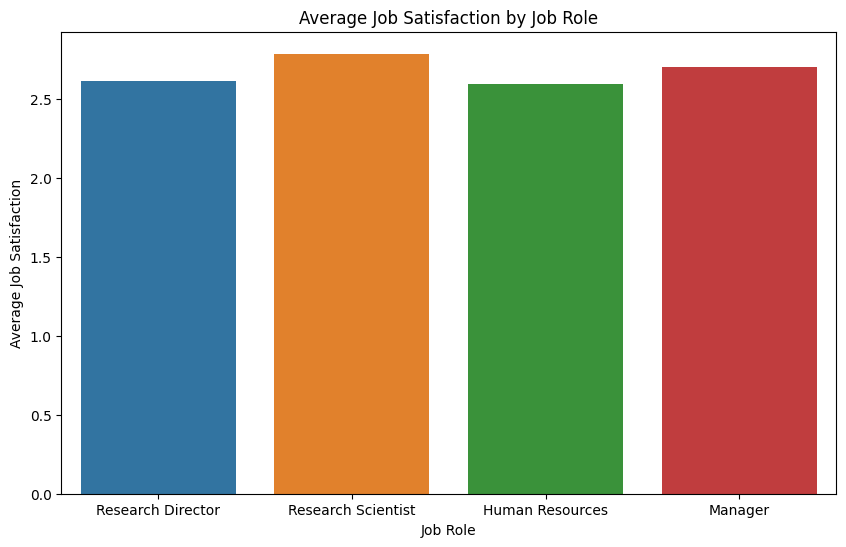

In [14]:
import seaborn as sns

selected_roles = ['Research Scientist', 'Human Resources', 'Manager', 'Research Director']

filtered_df = df[df['JobRole'].isin(selected_roles)]

plt.figure(figsize=(10, 6))
sns.barplot(x='JobRole', y='JobSatisfaction', data=filtered_df, errorbar=None)
plt.xlabel('Job Role')
plt.ylabel('Average Job Satisfaction')
plt.title('Average Job Satisfaction by Job Role')
plt.show()

Plot the average `MonthlyIncome` against the `YearsAtCompany`. **(P1-9: 1 point)**

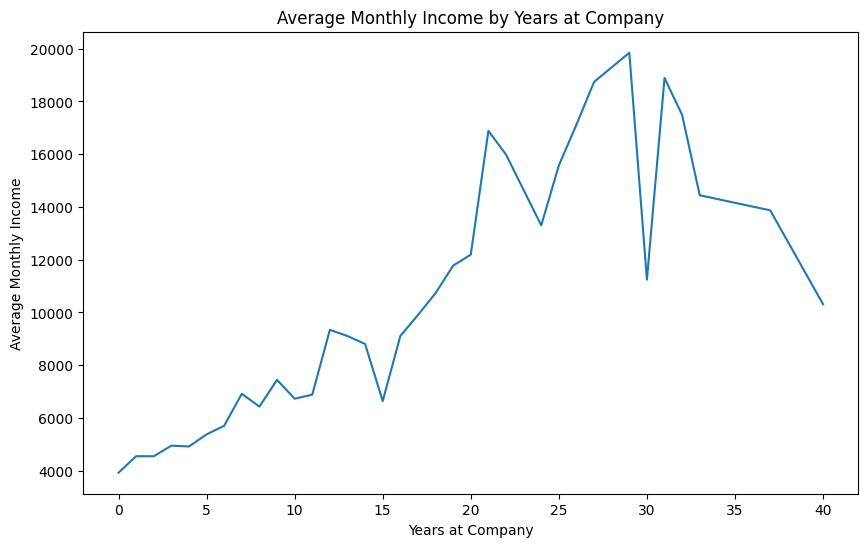

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='YearsAtCompany', y='MonthlyIncome', data=df, errorbar=None)
plt.xlabel('Years at Company')
plt.ylabel('Average Monthly Income')
plt.title('Average Monthly Income by Years at Company')
plt.show()

# P2: Pre-processing (9 points)

Label encode all categorical columns and split the data into train and test parts. The training part will further splitted into train and validation parts. **(P2-1: 2.5 points)**

In [16]:
# Label encode  (1.5 points)
from sklearn.preprocessing import LabelEncoder

df_categorical = df.select_dtypes(include=['object'])  # Select only categorical columns

label_encoder = LabelEncoder()

for column in df_categorical.columns:
    df[column] = label_encoder.fit_transform(df[column])
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_numeric
0,29,0,2,592,1,7,3,1,1883,4,...,2,0,11,2,3,3,2,1,2,1
1,36,0,2,884,2,1,4,1,1585,2,...,1,0,15,5,3,1,0,0,0,1
2,34,0,2,1326,2,3,3,4,1478,4,...,4,0,15,2,3,13,9,3,12,1
3,27,0,2,954,2,9,3,2,1965,4,...,1,0,7,5,3,7,7,0,7,1
4,32,0,2,929,2,10,3,2,722,4,...,4,0,10,2,2,10,7,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,35,0,2,750,1,28,3,1,1596,2,...,4,2,10,3,2,10,9,6,8,1
1098,41,0,2,447,1,5,3,1,1814,2,...,1,0,11,3,1,3,2,1,2,1
1099,22,1,1,1256,1,3,4,1,1203,3,...,2,1,1,5,3,0,0,0,0,2
1100,29,0,2,1378,1,13,2,4,2053,4,...,1,1,10,2,3,4,3,0,3,1


In [17]:
# split into train and validation (0.5 point)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
# lens of train and validation datasets (0.5 point)
print(len(train_df), len(val_df))


881 221


Further split the test dataframe into validation and test dataframes. **(P2-2: 0.5 point)**

In [19]:
test_df, val_df = train_test_split(val_df, test_size=0.5, random_state=42)
print(len(test_df), len(val_df))

110 111


Split the test and validation dataframe into feature and label part, Attrition columns is the target columns and rest of the columns should be treated as features. **(P2-3: 1 point)**

In [20]:
y_test = test_df['Attrition'].values
X_test = test_df.drop(columns = ['Attrition']).values

y_val = val_df['Attrition'].values
X_val = val_df.drop(columns = ['Attrition']).values


y_train = train_df['Attrition']
X_train = train_df.drop(columns = ['Attrition'])

check if the training dataset is label balanced. **(P2-4: 2 points)**

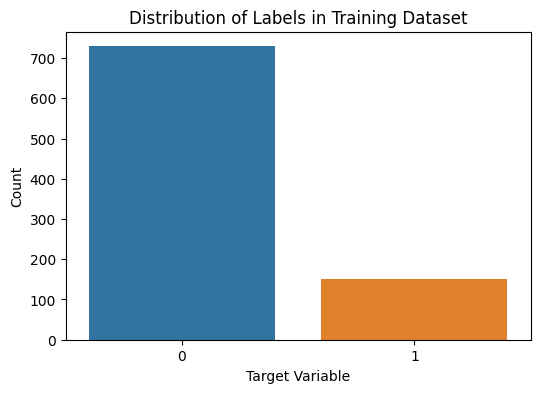

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Dataset')
plt.show()
## result showing that the dataset is not balanced clearly

Balance the training dataset by oversampling the class with less samples. **(P2-5: 2 points)**

Don't know oversampling? Read [this link](https://deeptip.ir/oversampling-and-undersampling-in-python/) (5 minutes)

In [22]:
# oversampling (1.5 points)
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)


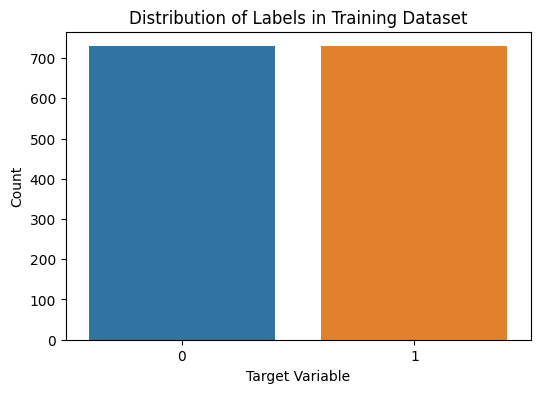

In [23]:
# check if dataset is balanced (0.5 point)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Dataset')
plt.show()

Split the training dataframe into feature and target columns. **(P2-6: 1 point)**

In [24]:
X_train = X_resampled.values
y_train = y_resampled.values

# P3: Decision tree from scratch (20 points)
Don't know Decision Tree? Read [this link](https://betterdatascience.com/mml-decision-trees/) (25 minutes).

Watch an introduction to Decision Trees [here](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk) (10 minutes).

Implement decision tree based on the given functions. **(P3-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [25]:
from collections import Counter
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        #stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        #grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        #parent loss
        parent_entropy = entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common


Define the model and train it. **(P3-2: 1 point)**

In [26]:
# model decleration and training
model = DecisionTree()
model.fit(X_train, y_train)

Predict the y_train and y_val values. **(P3-3: 1 point)**

In [27]:
# model predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

In [28]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 1.0,       0.7747747747747747
Train and validation recall are: 1.0,       0.2857142857142857
Train and validation f1 are: 1.0,       0.3243243243243243


Visulize (y_train, y_train_pred) using Heatmap **(P3-4: 1.5 points)**

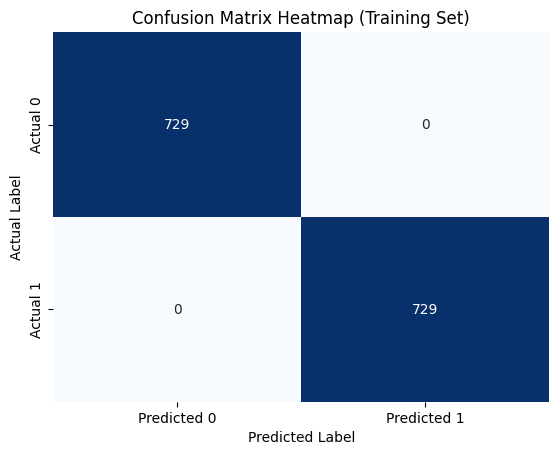

In [29]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Training Set)")
plt.show()

Visulize (y_val, y_val_pred) using Heatmap **(P3-5: 1.5 points)**

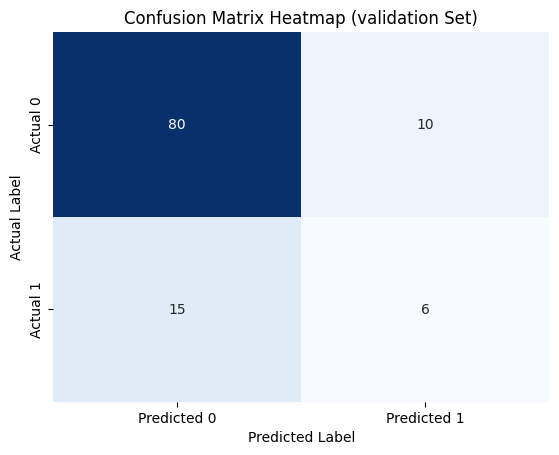

In [30]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (validation Set)")
plt.show()

# P4: Random forest from scratch (20 points)
Don't know Random Forest? Read [this link](https://quera.org/blog/random-forest-algorithm/) (15 minutes).

Implement Random Forest based on the given functions. **(P4-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [31]:
class RandomForest:
    def __init__(self, num_trees=10, max_depth=None, random_state=None, max_features=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass

In [32]:
from collections import Counter
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

Define the model and train it. **(P4-2: 1 point)**

In [33]:
model_rf = RandomForest()
model_rf.fit(X_train, y_train)

Predict the y_train and y_val values. **(P4-3: 1 point)**

In [34]:
y_train_pred = model_rf.predict(X_train)
y_val_pred =  model_rf.predict(X_val)

In [35]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.9993141289437586,       0.8018018018018018
Train and validation recall are: 1.0,       0.3333333333333333
Train and validation f1 are: 0.9993145990404386,       0.3888888888888889


Visulize (y_train, y_train_pred) using Heatmap **(P4-4: 1.5 points)**

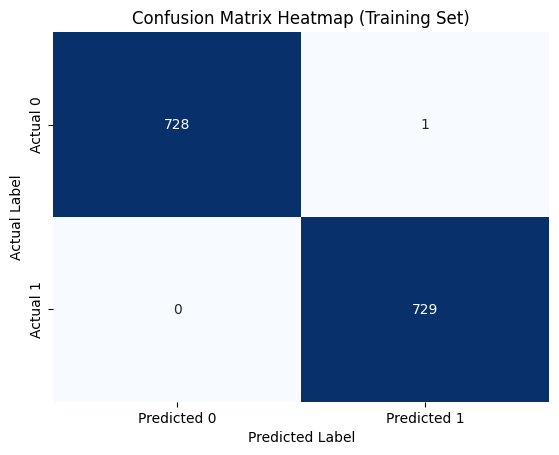

In [36]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Training Set)")
plt.show()

Visulize (y_val, y_val_pred) using Heatmap **(P4-5: 1.5 points)**

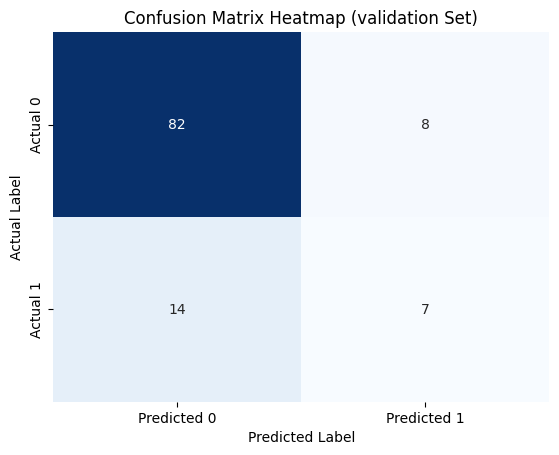

In [37]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (validation Set)")
plt.show()

# P5: Decision Tree (10 points)

Fit the data to a decision tree (of sklearn) with maximum depth of 2. **(P5-1: 2 points)**

In [38]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Model definition
model_sk_dt = DecisionTreeRegressor(max_depth = 2)
# Model fitting
model_sk_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

Plot the fitted decision tree. **(P5-2: 2 points)**

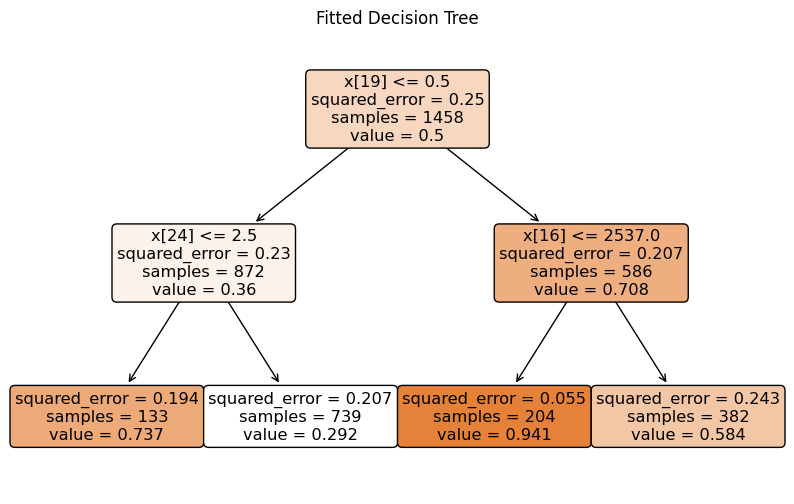

In [39]:
# Plot the fitted decision tree
plt.figure(figsize=(10, 6))
plot_tree(model_sk_dt, filled=True,rounded=True)
plt.title("Fitted Decision Tree")
plt.show()

Make predictions on training and validation set and calculate accuracy, recall and f1_score on them. **(P5-3: 1 point)**

In [40]:
y_train_pred = model_sk_dt.predict(X_train)
y_val_pred = model_sk_dt.predict(X_val)

In [41]:
y_train_pred = np.round(y_train_pred)
y_val_pred = np.round(y_val_pred)

In [42]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.710562414266118,       0.6756756756756757
Train and validation recall are: 0.7037037037037037,       0.6666666666666666
Train and validation f1 are: 0.7085635359116021,       0.4375


Plot the confusion matrices for the training and validation datasets. **(P5-4: 2 points)**

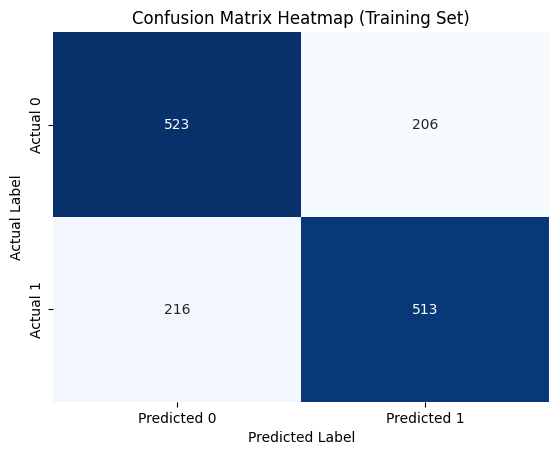

In [43]:
# 1 point for (y_train, y_train_pred)

conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Training Set)")
plt.show()

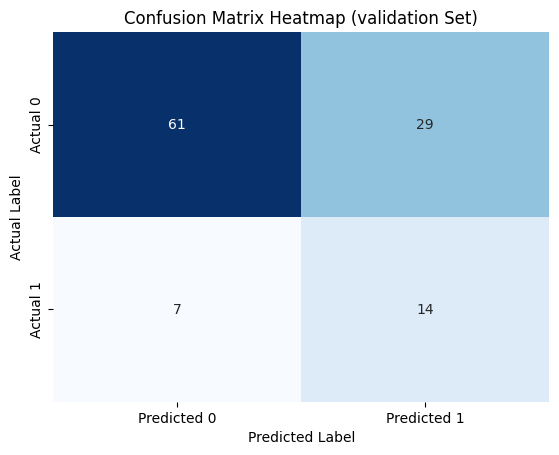

In [44]:
# 1 point for (y_val, y_val_pred)

conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (validation Set)")
plt.show()

Experiment with different depth trees and plot the f1_score associated with each depth on training and valication datasets. **(P5-5: 3 points)**

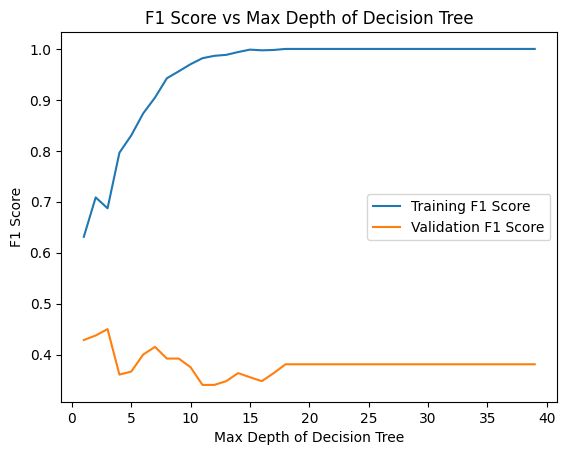

In [45]:
max_depths = range(1, 40)
train_f1_scores = []
val_f1_scores = []

for depth in max_depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)

    decision_tree.fit(X_train, y_train)

    y_train_pred = decision_tree.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred)

    y_val_pred = decision_tree.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred)

    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

plt.plot(max_depths, train_f1_scores, label='Training F1 Score')
plt.plot(max_depths, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Max Depth of Decision Tree')
plt.legend()
plt.show()

# P6: Random Forest (7 points)


Fit the training data to a random forest (of sklearn). **(P6-1: 2 points)**

In [46]:
from sklearn.ensemble import RandomForestClassifier
# Model definition
model_sk_rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
# Model fitting
model_sk_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

Plot the feature importances using a bar plot. **(P6-2: 2 points)**

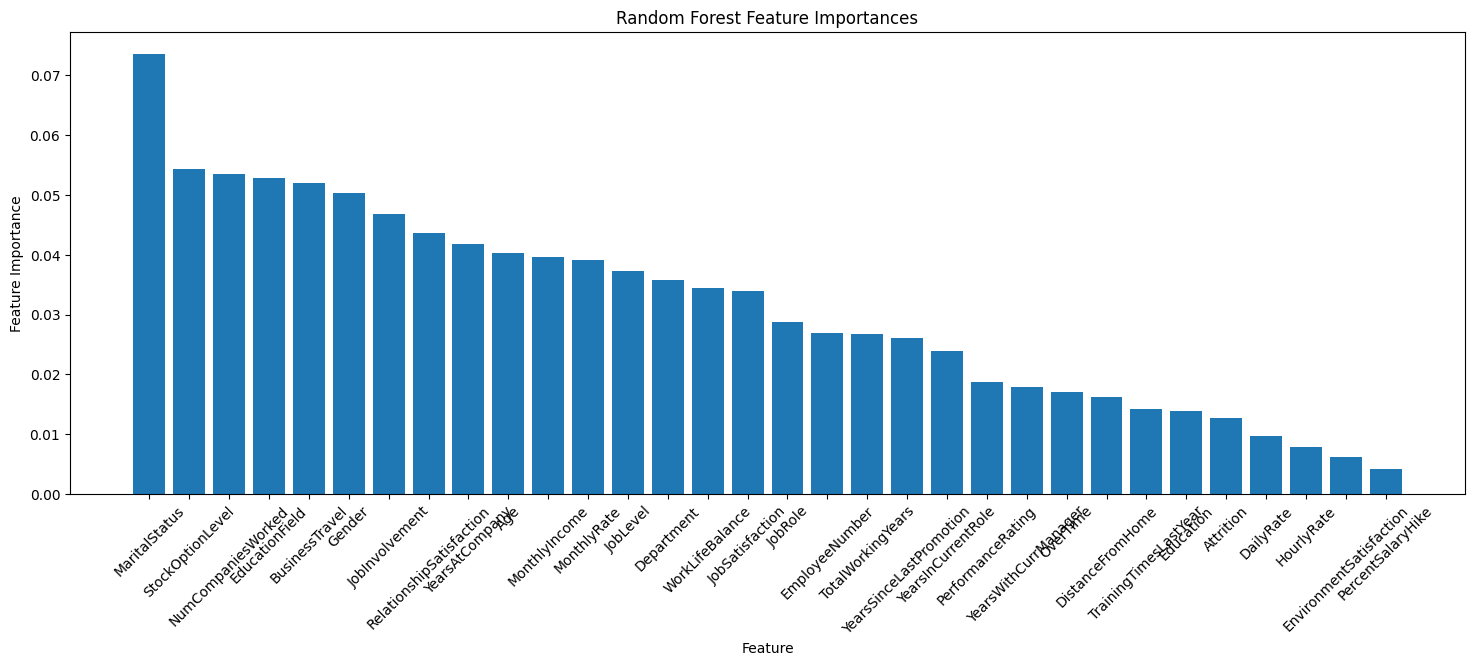

In [47]:
# Get feature importances from the model
feature_importances = model_sk_rf.feature_importances_

# Get feature names from the dataset
feature_names = train_df.columns  

# Sort indices based on feature importances
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(18, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P6-3: 1 point)**

In [48]:
y_train_pred = model_sk_rf.predict(X_train)
y_val_pred = model_sk_rf.predict(X_val)

In [49]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.9993141289437586,       0.7657657657657657
Train and validation recall are: 0.9986282578875172,       0.14285714285714285
Train and validation f1 are: 0.9993136582017845,       0.18749999999999997


Plot the confusion matrices for the training and validation datasets. **(P6-4: 2 points)**

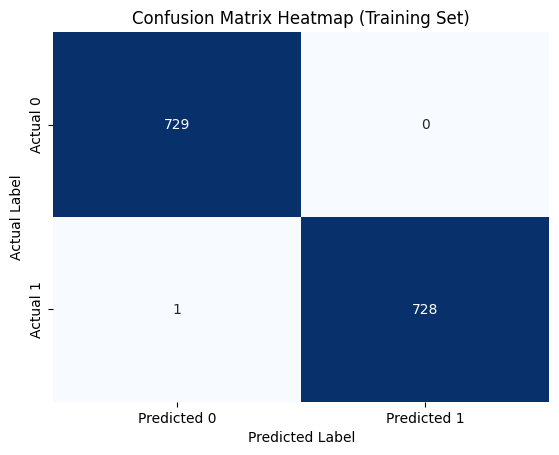

In [50]:
# 1 point for (y_train, y_train_pred)
conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Training Set)")
plt.show()

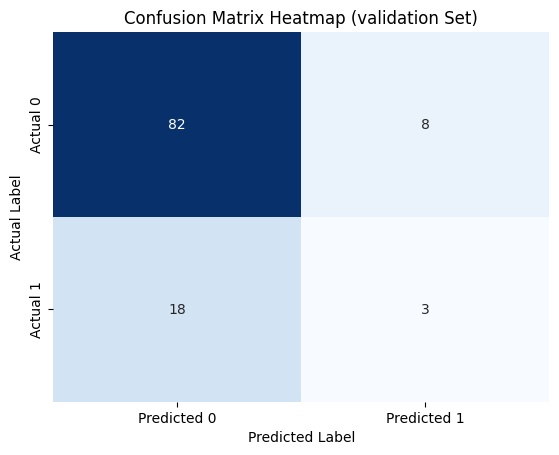

In [51]:
# 1 point for (y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (validation Set)")
plt.show()

# P7: Gradient Boosted Decision Trees (5 points)
Don't know GBD Tree? Follow [this link](https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/) (+30 minutes).

Fit a gradient boosted decision tree(e.g. catboost, lightgbm, xgboost). **(P7-1: 2 points)**

Using the catboost library is recommended

In [52]:
from catboost import CatBoostClassifier
# Model definition
model_cb = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42)
# Model fitting
model_cb.fit(X_train, y_train)

0:	learn: 0.6464713	total: 53.9ms	remaining: 5.33s
1:	learn: 0.5992879	total: 55.8ms	remaining: 2.73s
2:	learn: 0.5640195	total: 58.3ms	remaining: 1.89s
3:	learn: 0.5291442	total: 61.1ms	remaining: 1.47s
4:	learn: 0.5034497	total: 62.8ms	remaining: 1.19s
5:	learn: 0.4841984	total: 64.5ms	remaining: 1.01s
6:	learn: 0.4608821	total: 66.2ms	remaining: 880ms
7:	learn: 0.4417706	total: 67.9ms	remaining: 781ms
8:	learn: 0.4310854	total: 69.6ms	remaining: 703ms
9:	learn: 0.4136934	total: 71.2ms	remaining: 641ms
10:	learn: 0.4023427	total: 72.9ms	remaining: 590ms
11:	learn: 0.3890178	total: 74.6ms	remaining: 547ms
12:	learn: 0.3840582	total: 76.2ms	remaining: 510ms
13:	learn: 0.3720263	total: 78ms	remaining: 479ms
14:	learn: 0.3591974	total: 79.8ms	remaining: 452ms
15:	learn: 0.3487534	total: 81.5ms	remaining: 428ms
16:	learn: 0.3411318	total: 83.3ms	remaining: 407ms
17:	learn: 0.3339964	total: 84.9ms	remaining: 387ms
18:	learn: 0.3242139	total: 86.6ms	remaining: 369ms
19:	learn: 0.3156175	tot

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P7-2: 1 point)**

In [53]:
y_train_pred = model_cb.predict(X_train)
y_val_pred = model_cb.predict(X_val)

In [54]:
print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0,       0.8468468468468469
Train and test recall are: 1.0,       0.47619047619047616
Train and test f1 are: 1.0,       0.5405405405405405


Plot the confusion matrices for the training and validation datasets. **(P7-3: 2 points)**

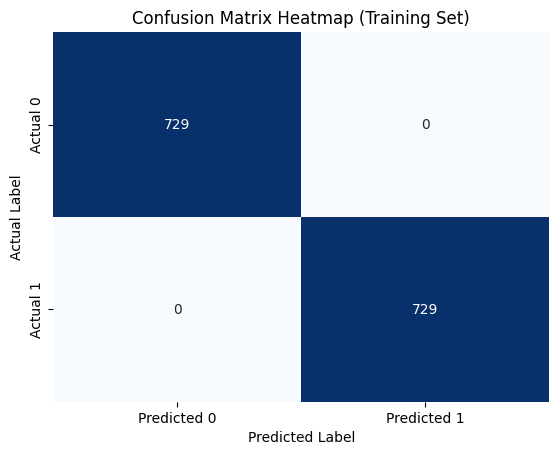

In [55]:
# 1 point for (y_train, y_train_pred)
conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Training Set)")
plt.show()

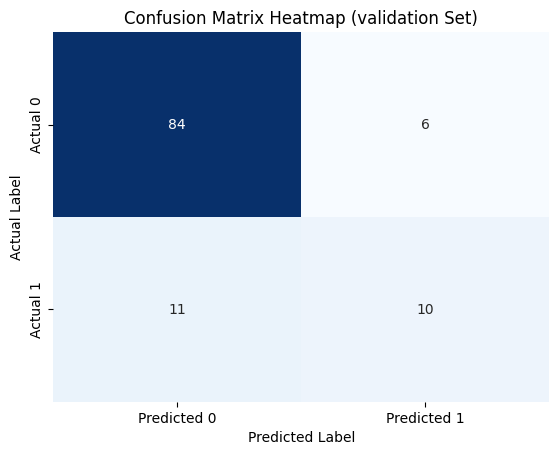

In [56]:
# 1 point for (y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (validation Set)")
plt.show()

# P8: Tuning parameters using optuna? (12 points)

There are many tunable parameters in Gradient boosted decision trees tuning all of them using grid search is almost impossible. There is no other choice for tuing hyperparameters unless you assume some models on behaviour of models under different hyperparameter choices e.g. the follow a gaussian process. Use the optuna library to tune the hyperparameters of gradient boosted decision tree. Report the results as in the previous parts. **(P8-1: 10 points)**

Do you want to get familiar more with it? Follow [this link](https://datagy.io/python-optuna/) (+40 minutes)

Do you know the difference between parameters and hyperparameters? If no, you can find more [here](https://virgool.io/@maryam.hasanali/%D9%87%D8%A7%DB%8C%D9%BE%D8%B1%D9%BE%D8%A7%D8%B1%D8%A7%D9%85%D8%AA%D8%B1%D9%87%D8%A7%DB%8C-%D8%AF%D8%B1-%DB%8C%DA%A9-%D9%85%D8%AF%D9%84-%DB%8C%D8%A7%D8%AF%DA%AF%DB%8C%D8%B1%DB%8C-%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%DA%86%DB%8C%D8%B3%D8%AA-%D9%88-%DA%86%DA%AF%D9%88%D9%86%D9%87-%D8%A2%D9%86-%D8%B1%D8%A7-%D8%AA%D9%86%D8%B8%DB%8C%D9%85-%DA%A9%D9%86%DB%8C%D9%85-o8zgjoouhwen) (3 minutes).

In [57]:
import optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }
    catboost_classifier = CatBoostClassifier(**params, random_state=42)

    catboost_classifier.fit(X_train, y_train)

    predictions = catboost_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial
trial_params = trial.params
trial_params

[I 2024-01-07 21:06:34,146] A new study created in memory with name: no-name-03ee58b7-71a2-4c8b-bf21-de5ac2822cfc


0:	learn: 0.5853317	total: 9.59ms	remaining: 1.57s
1:	learn: 0.4958365	total: 16.2ms	remaining: 1.32s
2:	learn: 0.4465419	total: 22.4ms	remaining: 1.21s
3:	learn: 0.3887259	total: 28.9ms	remaining: 1.16s
4:	learn: 0.3544603	total: 35ms	remaining: 1.12s
5:	learn: 0.3210229	total: 41.5ms	remaining: 1.1s
6:	learn: 0.2990100	total: 47.5ms	remaining: 1.07s
7:	learn: 0.2686619	total: 53.3ms	remaining: 1.04s
8:	learn: 0.2443522	total: 59.1ms	remaining: 1.02s
9:	learn: 0.2220872	total: 64.9ms	remaining: 1.01s
10:	learn: 0.2092091	total: 71.2ms	remaining: 997ms
11:	learn: 0.1940891	total: 77.3ms	remaining: 986ms
12:	learn: 0.1796859	total: 82.8ms	remaining: 968ms
13:	learn: 0.1660278	total: 88.9ms	remaining: 959ms
14:	learn: 0.1524871	total: 94.6ms	remaining: 946ms
15:	learn: 0.1413140	total: 100ms	remaining: 934ms
16:	learn: 0.1337389	total: 106ms	remaining: 923ms
17:	learn: 0.1253793	total: 113ms	remaining: 921ms
18:	learn: 0.1182701	total: 119ms	remaining: 912ms
19:	learn: 0.1135659	total: 1

[I 2024-01-07 21:06:35,246] Trial 0 finished with value: 0.8636363636363636 and parameters: {'iterations': 165, 'learning_rate': 0.1874515887239707, 'depth': 9, 'l2_leaf_reg': 6.169400485422224, 'border_count': 236}. Best is trial 0 with value: 0.8636363636363636.
[I 2024-01-07 21:06:35,407] Trial 1 finished with value: 0.8545454545454545 and parameters: {'iterations': 66, 'learning_rate': 0.12692830691165552, 'depth': 7, 'l2_leaf_reg': 9.930307336086376, 'border_count': 85}. Best is trial 0 with value: 0.8636363636363636.


0:	learn: 0.6339737	total: 2.47ms	remaining: 161ms
1:	learn: 0.5772619	total: 4.58ms	remaining: 147ms
2:	learn: 0.5423043	total: 6.28ms	remaining: 132ms
3:	learn: 0.5074751	total: 8.08ms	remaining: 125ms
4:	learn: 0.4777520	total: 9.82ms	remaining: 120ms
5:	learn: 0.4580503	total: 11.5ms	remaining: 115ms
6:	learn: 0.4348999	total: 13.1ms	remaining: 111ms
7:	learn: 0.4181231	total: 14.8ms	remaining: 108ms
8:	learn: 0.4017104	total: 16.5ms	remaining: 105ms
9:	learn: 0.3878447	total: 18.2ms	remaining: 102ms
10:	learn: 0.3703273	total: 20ms	remaining: 100ms
11:	learn: 0.3575031	total: 22ms	remaining: 99.2ms
12:	learn: 0.3433211	total: 23.7ms	remaining: 96.8ms
13:	learn: 0.3323791	total: 25.5ms	remaining: 94.6ms
14:	learn: 0.3246918	total: 27.1ms	remaining: 92.2ms
15:	learn: 0.3114147	total: 28.8ms	remaining: 89.9ms
16:	learn: 0.3032370	total: 30.4ms	remaining: 87.7ms
17:	learn: 0.2976496	total: 32.3ms	remaining: 86ms
18:	learn: 0.2853613	total: 34ms	remaining: 84.1ms
19:	learn: 0.2741326	t

[I 2024-01-07 21:06:37,170] Trial 2 finished with value: 0.8545454545454545 and parameters: {'iterations': 160, 'learning_rate': 0.289261217785709, 'depth': 10, 'l2_leaf_reg': 7.497436063003718, 'border_count': 241}. Best is trial 0 with value: 0.8636363636363636.
[I 2024-01-07 21:06:37,292] Trial 3 finished with value: 0.8727272727272727 and parameters: {'iterations': 71, 'learning_rate': 0.1332867550998876, 'depth': 5, 'l2_leaf_reg': 2.356798602438996, 'border_count': 135}. Best is trial 3 with value: 0.8727272727272727.


159:	learn: 0.0045141	total: 1.69s	remaining: 0us
0:	learn: 0.6426647	total: 1.44ms	remaining: 101ms
1:	learn: 0.5999168	total: 2.72ms	remaining: 93.7ms
2:	learn: 0.5676300	total: 3.92ms	remaining: 88.9ms
3:	learn: 0.5321607	total: 5.15ms	remaining: 86.3ms
4:	learn: 0.5088969	total: 6.29ms	remaining: 83.1ms
5:	learn: 0.4896130	total: 7.46ms	remaining: 80.8ms
6:	learn: 0.4663335	total: 8.65ms	remaining: 79.1ms
7:	learn: 0.4534451	total: 9.82ms	remaining: 77.4ms
8:	learn: 0.4391017	total: 11ms	remaining: 75.9ms
9:	learn: 0.4268659	total: 12.3ms	remaining: 74.9ms
10:	learn: 0.4152779	total: 13.5ms	remaining: 73.4ms
11:	learn: 0.4043346	total: 14.7ms	remaining: 72ms
12:	learn: 0.3948038	total: 15.8ms	remaining: 70.4ms
13:	learn: 0.3860861	total: 17ms	remaining: 69ms
14:	learn: 0.3742626	total: 18.1ms	remaining: 67.5ms
15:	learn: 0.3664287	total: 19.3ms	remaining: 66.4ms
16:	learn: 0.3582419	total: 20.5ms	remaining: 65.1ms
17:	learn: 0.3500946	total: 21.7ms	remaining: 64ms
18:	learn: 0.3440

[I 2024-01-07 21:06:37,532] Trial 4 finished with value: 0.8363636363636363 and parameters: {'iterations': 113, 'learning_rate': 0.14049328757131022, 'depth': 6, 'l2_leaf_reg': 6.706539691220267, 'border_count': 173}. Best is trial 3 with value: 0.8727272727272727.


20:	learn: 0.2800606	total: 33.1ms	remaining: 145ms
21:	learn: 0.2746972	total: 35.2ms	remaining: 145ms
22:	learn: 0.2636803	total: 37.3ms	remaining: 146ms
23:	learn: 0.2577016	total: 39.1ms	remaining: 145ms
24:	learn: 0.2538172	total: 41ms	remaining: 144ms
25:	learn: 0.2490673	total: 42.7ms	remaining: 143ms
26:	learn: 0.2429907	total: 44.5ms	remaining: 142ms
27:	learn: 0.2343146	total: 46.3ms	remaining: 141ms
28:	learn: 0.2285984	total: 48.1ms	remaining: 139ms
29:	learn: 0.2248455	total: 49.8ms	remaining: 138ms
30:	learn: 0.2204596	total: 51.6ms	remaining: 136ms
31:	learn: 0.2139049	total: 53.4ms	remaining: 135ms
32:	learn: 0.2089660	total: 55.2ms	remaining: 134ms
33:	learn: 0.2058645	total: 57ms	remaining: 132ms
34:	learn: 0.2003588	total: 58.8ms	remaining: 131ms
35:	learn: 0.1949567	total: 60.6ms	remaining: 130ms
36:	learn: 0.1918627	total: 62.3ms	remaining: 128ms
37:	learn: 0.1879446	total: 64.2ms	remaining: 127ms
38:	learn: 0.1847963	total: 66ms	remaining: 125ms
39:	learn: 0.18167

[I 2024-01-07 21:06:39,430] Trial 5 finished with value: 0.8363636363636363 and parameters: {'iterations': 180, 'learning_rate': 0.2418863478643857, 'depth': 10, 'l2_leaf_reg': 5.789164827810302, 'border_count': 219}. Best is trial 3 with value: 0.8727272727272727.


0:	learn: 0.5678193	total: 5.48ms	remaining: 893ms
1:	learn: 0.4685542	total: 10.8ms	remaining: 872ms
2:	learn: 0.3896338	total: 15.8ms	remaining: 846ms
3:	learn: 0.3310256	total: 20.9ms	remaining: 837ms
4:	learn: 0.2943217	total: 26.1ms	remaining: 830ms
5:	learn: 0.2546333	total: 31.3ms	remaining: 824ms
6:	learn: 0.2252943	total: 36.8ms	remaining: 826ms
7:	learn: 0.2038025	total: 42ms	remaining: 820ms
8:	learn: 0.1861571	total: 47.2ms	remaining: 813ms
9:	learn: 0.1754167	total: 52.4ms	remaining: 807ms
10:	learn: 0.1611689	total: 57.8ms	remaining: 804ms
11:	learn: 0.1449370	total: 63.3ms	remaining: 802ms
12:	learn: 0.1352637	total: 69ms	remaining: 801ms
13:	learn: 0.1245026	total: 74.6ms	remaining: 800ms
14:	learn: 0.1167076	total: 80.3ms	remaining: 798ms
15:	learn: 0.1065888	total: 87.2ms	remaining: 807ms
16:	learn: 0.1029979	total: 93ms	remaining: 804ms
17:	learn: 0.0952902	total: 98.6ms	remaining: 800ms
18:	learn: 0.0893714	total: 104ms	remaining: 796ms
19:	learn: 0.0826614	total: 1

[I 2024-01-07 21:06:40,412] Trial 6 finished with value: 0.8272727272727273 and parameters: {'iterations': 164, 'learning_rate': 0.18541033928044234, 'depth': 10, 'l2_leaf_reg': 4.344621257352027, 'border_count': 63}. Best is trial 3 with value: 0.8727272727272727.


144:	learn: 0.0052152	total: 805ms	remaining: 106ms
145:	learn: 0.0051660	total: 812ms	remaining: 100ms
146:	learn: 0.0051272	total: 817ms	remaining: 94.5ms
147:	learn: 0.0050812	total: 823ms	remaining: 88.9ms
148:	learn: 0.0050318	total: 828ms	remaining: 83.4ms
149:	learn: 0.0049925	total: 834ms	remaining: 77.8ms
150:	learn: 0.0049499	total: 839ms	remaining: 72.3ms
151:	learn: 0.0049096	total: 845ms	remaining: 66.7ms
152:	learn: 0.0048752	total: 850ms	remaining: 61.1ms
153:	learn: 0.0048313	total: 856ms	remaining: 55.6ms
154:	learn: 0.0047865	total: 861ms	remaining: 50ms
155:	learn: 0.0047474	total: 867ms	remaining: 44.4ms
156:	learn: 0.0046960	total: 872ms	remaining: 38.9ms
157:	learn: 0.0046411	total: 877ms	remaining: 33.3ms
158:	learn: 0.0046116	total: 883ms	remaining: 27.8ms
159:	learn: 0.0045761	total: 888ms	remaining: 22.2ms
160:	learn: 0.0045409	total: 893ms	remaining: 16.6ms
161:	learn: 0.0045036	total: 899ms	remaining: 11.1ms
162:	learn: 0.0044655	total: 904ms	remaining: 5.55

[I 2024-01-07 21:06:40,769] Trial 7 finished with value: 0.8363636363636363 and parameters: {'iterations': 174, 'learning_rate': 0.1448054759833578, 'depth': 6, 'l2_leaf_reg': 3.452896424585359, 'border_count': 196}. Best is trial 3 with value: 0.8727272727272727.


136:	learn: 0.0169208	total: 241ms	remaining: 65.1ms
137:	learn: 0.0166171	total: 243ms	remaining: 63.5ms
138:	learn: 0.0165204	total: 245ms	remaining: 61.8ms
139:	learn: 0.0164360	total: 247ms	remaining: 60ms
140:	learn: 0.0162374	total: 249ms	remaining: 58.3ms
141:	learn: 0.0160080	total: 251ms	remaining: 56.5ms
142:	learn: 0.0158317	total: 253ms	remaining: 54.8ms
143:	learn: 0.0156590	total: 254ms	remaining: 53ms
144:	learn: 0.0153593	total: 256ms	remaining: 51.3ms
145:	learn: 0.0152825	total: 258ms	remaining: 49.5ms
146:	learn: 0.0150807	total: 260ms	remaining: 47.7ms
147:	learn: 0.0148716	total: 262ms	remaining: 46ms
148:	learn: 0.0145617	total: 263ms	remaining: 44.2ms
149:	learn: 0.0142764	total: 265ms	remaining: 42.5ms
150:	learn: 0.0141500	total: 267ms	remaining: 40.7ms
151:	learn: 0.0139539	total: 269ms	remaining: 38.9ms
152:	learn: 0.0137474	total: 271ms	remaining: 37.2ms
153:	learn: 0.0135014	total: 273ms	remaining: 35.4ms
154:	learn: 0.0134537	total: 275ms	remaining: 33.7ms

[I 2024-01-07 21:06:41,050] Trial 8 finished with value: 0.8363636363636363 and parameters: {'iterations': 178, 'learning_rate': 0.20413818008833867, 'depth': 4, 'l2_leaf_reg': 3.8529622481949106, 'border_count': 207}. Best is trial 3 with value: 0.8727272727272727.


68:	learn: 0.1352186	total: 90.9ms	remaining: 144ms
69:	learn: 0.1317530	total: 92.6ms	remaining: 143ms
70:	learn: 0.1293864	total: 94.5ms	remaining: 142ms
71:	learn: 0.1267246	total: 95.8ms	remaining: 141ms
72:	learn: 0.1236083	total: 97.1ms	remaining: 140ms
73:	learn: 0.1221936	total: 98.4ms	remaining: 138ms
74:	learn: 0.1192099	total: 99.7ms	remaining: 137ms
75:	learn: 0.1167431	total: 101ms	remaining: 136ms
76:	learn: 0.1153926	total: 102ms	remaining: 134ms
77:	learn: 0.1133997	total: 104ms	remaining: 133ms
78:	learn: 0.1107460	total: 105ms	remaining: 132ms
79:	learn: 0.1089152	total: 106ms	remaining: 130ms
80:	learn: 0.1069744	total: 108ms	remaining: 129ms
81:	learn: 0.1048227	total: 109ms	remaining: 127ms
82:	learn: 0.1027171	total: 110ms	remaining: 126ms
83:	learn: 0.1005664	total: 112ms	remaining: 125ms
84:	learn: 0.0991375	total: 113ms	remaining: 123ms
85:	learn: 0.0978828	total: 114ms	remaining: 122ms
86:	learn: 0.0963733	total: 115ms	remaining: 121ms
87:	learn: 0.0948603	tot

[I 2024-01-07 21:06:41,829] Trial 9 finished with value: 0.8727272727272727 and parameters: {'iterations': 189, 'learning_rate': 0.27825488402369397, 'depth': 9, 'l2_leaf_reg': 6.620137253322945, 'border_count': 97}. Best is trial 3 with value: 0.8727272727272727.


160:	learn: 0.0041039	total: 612ms	remaining: 106ms
161:	learn: 0.0040745	total: 616ms	remaining: 103ms
162:	learn: 0.0040427	total: 620ms	remaining: 98.9ms
163:	learn: 0.0040142	total: 624ms	remaining: 95.1ms
164:	learn: 0.0039873	total: 628ms	remaining: 91.3ms
165:	learn: 0.0039564	total: 631ms	remaining: 87.5ms
166:	learn: 0.0039229	total: 635ms	remaining: 83.7ms
167:	learn: 0.0039024	total: 639ms	remaining: 79.8ms
168:	learn: 0.0038767	total: 642ms	remaining: 76ms
169:	learn: 0.0038512	total: 646ms	remaining: 72.2ms
170:	learn: 0.0038231	total: 650ms	remaining: 68.4ms
171:	learn: 0.0037981	total: 654ms	remaining: 64.6ms
172:	learn: 0.0037694	total: 657ms	remaining: 60.8ms
173:	learn: 0.0037387	total: 661ms	remaining: 57ms
174:	learn: 0.0037071	total: 665ms	remaining: 53.2ms
175:	learn: 0.0036837	total: 669ms	remaining: 49.4ms
176:	learn: 0.0036598	total: 672ms	remaining: 45.6ms
177:	learn: 0.0036293	total: 676ms	remaining: 41.8ms
178:	learn: 0.0036052	total: 680ms	remaining: 38ms
1

[I 2024-01-07 21:06:41,954] Trial 10 finished with value: 0.8363636363636363 and parameters: {'iterations': 54, 'learning_rate': 0.027859478151062184, 'depth': 4, 'l2_leaf_reg': 0.5637454416732863, 'border_count': 139}. Best is trial 3 with value: 0.8727272727272727.


22:	learn: 0.5466958	total: 24.2ms	remaining: 32.6ms
23:	learn: 0.5431907	total: 25.4ms	remaining: 31.7ms
24:	learn: 0.5400615	total: 26.6ms	remaining: 30.8ms
25:	learn: 0.5367565	total: 28.4ms	remaining: 30.6ms
26:	learn: 0.5340022	total: 29.7ms	remaining: 29.7ms
27:	learn: 0.5309145	total: 31ms	remaining: 28.7ms
28:	learn: 0.5272034	total: 32.2ms	remaining: 27.8ms
29:	learn: 0.5238175	total: 33.4ms	remaining: 26.7ms
30:	learn: 0.5214844	total: 34.7ms	remaining: 25.7ms
31:	learn: 0.5191248	total: 35.9ms	remaining: 24.7ms
32:	learn: 0.5160450	total: 37.1ms	remaining: 23.6ms
33:	learn: 0.5130450	total: 38.3ms	remaining: 22.6ms
34:	learn: 0.5104344	total: 39.6ms	remaining: 21.5ms
35:	learn: 0.5073290	total: 40.8ms	remaining: 20.4ms
36:	learn: 0.5051151	total: 42.1ms	remaining: 19.3ms
37:	learn: 0.5028293	total: 43.3ms	remaining: 18.2ms
38:	learn: 0.5010277	total: 44.6ms	remaining: 17.1ms
39:	learn: 0.4989694	total: 45.9ms	remaining: 16.1ms
40:	learn: 0.4969098	total: 47.1ms	remaining: 14

[I 2024-01-07 21:06:42,298] Trial 11 finished with value: 0.8818181818181818 and parameters: {'iterations': 99, 'learning_rate': 0.08043052851878121, 'depth': 8, 'l2_leaf_reg': 1.2469593336795235, 'border_count': 113}. Best is trial 11 with value: 0.8818181818181818.


36:	learn: 0.1078900	total: 103ms	remaining: 172ms
37:	learn: 0.1025221	total: 106ms	remaining: 171ms
38:	learn: 0.0994267	total: 111ms	remaining: 170ms
39:	learn: 0.0959103	total: 113ms	remaining: 167ms
40:	learn: 0.0933411	total: 116ms	remaining: 164ms
41:	learn: 0.0906803	total: 118ms	remaining: 161ms
42:	learn: 0.0884031	total: 121ms	remaining: 158ms
43:	learn: 0.0844255	total: 124ms	remaining: 155ms
44:	learn: 0.0830972	total: 127ms	remaining: 152ms
45:	learn: 0.0804212	total: 129ms	remaining: 149ms
46:	learn: 0.0773000	total: 132ms	remaining: 146ms
47:	learn: 0.0747525	total: 135ms	remaining: 143ms
48:	learn: 0.0720645	total: 138ms	remaining: 141ms
49:	learn: 0.0698566	total: 140ms	remaining: 138ms
50:	learn: 0.0678607	total: 143ms	remaining: 135ms
51:	learn: 0.0661914	total: 146ms	remaining: 132ms
52:	learn: 0.0638923	total: 150ms	remaining: 130ms
53:	learn: 0.0622862	total: 152ms	remaining: 127ms
54:	learn: 0.0609717	total: 155ms	remaining: 124ms
55:	learn: 0.0598385	total: 158

[I 2024-01-07 21:06:42,556] Trial 12 finished with value: 0.8181818181818182 and parameters: {'iterations': 90, 'learning_rate': 0.06675406264613643, 'depth': 7, 'l2_leaf_reg': 1.1498853583442525, 'border_count': 131}. Best is trial 11 with value: 0.8818181818181818.
[I 2024-01-07 21:06:42,774] Trial 13 finished with value: 0.8181818181818182 and parameters: {'iterations': 90, 'learning_rate': 0.08935091090457636, 'depth': 5, 'l2_leaf_reg': 2.1673812519604905, 'border_count': 117}. Best is trial 11 with value: 0.8818181818181818.


0:	learn: 0.6581548	total: 1.72ms	remaining: 153ms
1:	learn: 0.6258892	total: 3.64ms	remaining: 160ms
2:	learn: 0.6052563	total: 5.1ms	remaining: 148ms
3:	learn: 0.5812808	total: 6.62ms	remaining: 142ms
4:	learn: 0.5614091	total: 8.16ms	remaining: 139ms
5:	learn: 0.5457778	total: 9.65ms	remaining: 135ms
6:	learn: 0.5289903	total: 11.2ms	remaining: 133ms
7:	learn: 0.5127458	total: 12.8ms	remaining: 131ms
8:	learn: 0.4963518	total: 14.4ms	remaining: 129ms
9:	learn: 0.4858013	total: 15.9ms	remaining: 127ms
10:	learn: 0.4769105	total: 17.4ms	remaining: 125ms
11:	learn: 0.4656430	total: 19ms	remaining: 123ms
12:	learn: 0.4564464	total: 20.5ms	remaining: 121ms
13:	learn: 0.4456833	total: 22ms	remaining: 120ms
14:	learn: 0.4392822	total: 23.4ms	remaining: 117ms
15:	learn: 0.4313639	total: 25ms	remaining: 115ms
16:	learn: 0.4211866	total: 26.5ms	remaining: 114ms
17:	learn: 0.4135444	total: 28ms	remaining: 112ms
18:	learn: 0.4033844	total: 29.5ms	remaining: 110ms
19:	learn: 0.3940206	total: 31m

[I 2024-01-07 21:06:43,227] Trial 14 finished with value: 0.8363636363636363 and parameters: {'iterations': 124, 'learning_rate': 0.09194015340330217, 'depth': 8, 'l2_leaf_reg': 2.2632928102235166, 'border_count': 40}. Best is trial 11 with value: 0.8818181818181818.


72:	learn: 0.0402712	total: 199ms	remaining: 139ms
73:	learn: 0.0395066	total: 203ms	remaining: 137ms
74:	learn: 0.0384796	total: 207ms	remaining: 135ms
75:	learn: 0.0378433	total: 210ms	remaining: 133ms
76:	learn: 0.0368556	total: 219ms	remaining: 133ms
77:	learn: 0.0358729	total: 222ms	remaining: 131ms
78:	learn: 0.0351233	total: 226ms	remaining: 129ms
79:	learn: 0.0345167	total: 232ms	remaining: 128ms
80:	learn: 0.0335760	total: 236ms	remaining: 126ms
81:	learn: 0.0328288	total: 239ms	remaining: 122ms
82:	learn: 0.0320555	total: 243ms	remaining: 120ms
83:	learn: 0.0312693	total: 246ms	remaining: 117ms
84:	learn: 0.0305019	total: 249ms	remaining: 114ms
85:	learn: 0.0299805	total: 251ms	remaining: 111ms
86:	learn: 0.0295251	total: 254ms	remaining: 108ms
87:	learn: 0.0290994	total: 257ms	remaining: 105ms
88:	learn: 0.0282791	total: 261ms	remaining: 103ms
89:	learn: 0.0275162	total: 263ms	remaining: 99.5ms
90:	learn: 0.0269380	total: 266ms	remaining: 96.5ms
91:	learn: 0.0262613	total: 2

[I 2024-01-07 21:06:43,480] Trial 15 finished with value: 0.8181818181818182 and parameters: {'iterations': 88, 'learning_rate': 0.015497344221810122, 'depth': 6, 'l2_leaf_reg': 0.12420723514580434, 'border_count': 176}. Best is trial 11 with value: 0.8818181818181818.


0:	learn: 0.6840967	total: 2.5ms	remaining: 217ms
1:	learn: 0.6727986	total: 5.08ms	remaining: 219ms
2:	learn: 0.6620300	total: 7.48ms	remaining: 212ms
3:	learn: 0.6522500	total: 9.77ms	remaining: 205ms
4:	learn: 0.6457035	total: 12.3ms	remaining: 205ms
5:	learn: 0.6380462	total: 14.6ms	remaining: 199ms
6:	learn: 0.6304357	total: 17.2ms	remaining: 199ms
7:	learn: 0.6220131	total: 19.5ms	remaining: 195ms
8:	learn: 0.6132507	total: 21.7ms	remaining: 190ms
9:	learn: 0.6049379	total: 24ms	remaining: 187ms
10:	learn: 0.5979691	total: 26.3ms	remaining: 184ms
11:	learn: 0.5902345	total: 28.2ms	remaining: 178ms
12:	learn: 0.5846364	total: 30.1ms	remaining: 173ms
13:	learn: 0.5761645	total: 32.1ms	remaining: 170ms
14:	learn: 0.5712714	total: 34.1ms	remaining: 166ms
15:	learn: 0.5669865	total: 36ms	remaining: 162ms
16:	learn: 0.5599694	total: 38ms	remaining: 159ms
17:	learn: 0.5530724	total: 39.9ms	remaining: 155ms
18:	learn: 0.5445431	total: 41.9ms	remaining: 152ms
19:	learn: 0.5389040	total: 4

[I 2024-01-07 21:06:43,808] Trial 16 finished with value: 0.8454545454545455 and parameters: {'iterations': 71, 'learning_rate': 0.061812553251613306, 'depth': 8, 'l2_leaf_reg': 2.159592727667037, 'border_count': 162}. Best is trial 11 with value: 0.8818181818181818.


55:	learn: 0.1064793	total: 205ms	remaining: 54.9ms
56:	learn: 0.1045985	total: 209ms	remaining: 51.2ms
57:	learn: 0.1024489	total: 212ms	remaining: 47.5ms
58:	learn: 0.0999091	total: 216ms	remaining: 43.8ms
59:	learn: 0.0987318	total: 219ms	remaining: 40.2ms
60:	learn: 0.0963382	total: 222ms	remaining: 36.5ms
61:	learn: 0.0935974	total: 226ms	remaining: 32.8ms
62:	learn: 0.0908362	total: 229ms	remaining: 29.1ms
63:	learn: 0.0886865	total: 233ms	remaining: 25.5ms
64:	learn: 0.0872846	total: 236ms	remaining: 21.8ms
65:	learn: 0.0849785	total: 240ms	remaining: 18.2ms
66:	learn: 0.0828287	total: 243ms	remaining: 14.5ms
67:	learn: 0.0810053	total: 247ms	remaining: 10.9ms
68:	learn: 0.0793015	total: 250ms	remaining: 7.25ms
69:	learn: 0.0778895	total: 254ms	remaining: 3.63ms
70:	learn: 0.0778318	total: 255ms	remaining: 0us
0:	learn: 0.6528191	total: 1.71ms	remaining: 242ms
1:	learn: 0.6171974	total: 3.25ms	remaining: 229ms
2:	learn: 0.5922351	total: 4.73ms	remaining: 221ms
3:	learn: 0.567081

[I 2024-01-07 21:06:44,098] Trial 17 finished with value: 0.8545454545454545 and parameters: {'iterations': 143, 'learning_rate': 0.1046772798995588, 'depth': 5, 'l2_leaf_reg': 3.183903361146821, 'border_count': 104}. Best is trial 11 with value: 0.8818181818181818.


52:	learn: 0.2318068	total: 82.4ms	remaining: 140ms
53:	learn: 0.2288497	total: 84.5ms	remaining: 139ms
54:	learn: 0.2242071	total: 86.3ms	remaining: 138ms
55:	learn: 0.2200874	total: 88ms	remaining: 137ms
56:	learn: 0.2159087	total: 89.5ms	remaining: 135ms
57:	learn: 0.2140679	total: 91ms	remaining: 133ms
58:	learn: 0.2106465	total: 92.5ms	remaining: 132ms
59:	learn: 0.2084236	total: 93.9ms	remaining: 130ms
60:	learn: 0.2042463	total: 95.5ms	remaining: 128ms
61:	learn: 0.2015900	total: 97ms	remaining: 127ms
62:	learn: 0.1988530	total: 98.4ms	remaining: 125ms
63:	learn: 0.1958728	total: 100ms	remaining: 124ms
64:	learn: 0.1935398	total: 102ms	remaining: 122ms
65:	learn: 0.1907088	total: 103ms	remaining: 120ms
66:	learn: 0.1881890	total: 105ms	remaining: 119ms
67:	learn: 0.1859950	total: 106ms	remaining: 117ms
68:	learn: 0.1842351	total: 107ms	remaining: 115ms
69:	learn: 0.1814411	total: 109ms	remaining: 114ms
70:	learn: 0.1792548	total: 110ms	remaining: 112ms
71:	learn: 0.1774607	total

[I 2024-01-07 21:06:44,478] Trial 18 finished with value: 0.8636363636363636 and parameters: {'iterations': 109, 'learning_rate': 0.04524313935486661, 'depth': 8, 'l2_leaf_reg': 1.317096934877524, 'border_count': 154}. Best is trial 11 with value: 0.8818181818181818.


70:	learn: 0.1049895	total: 200ms	remaining: 107ms
71:	learn: 0.1033864	total: 204ms	remaining: 105ms
72:	learn: 0.1012821	total: 207ms	remaining: 102ms
73:	learn: 0.0994822	total: 210ms	remaining: 99.2ms
74:	learn: 0.0980128	total: 212ms	remaining: 96.3ms
75:	learn: 0.0957271	total: 215ms	remaining: 93.4ms
76:	learn: 0.0937340	total: 218ms	remaining: 90.5ms
77:	learn: 0.0915894	total: 220ms	remaining: 87.6ms
78:	learn: 0.0903131	total: 223ms	remaining: 84.7ms
79:	learn: 0.0896803	total: 226ms	remaining: 81.8ms
80:	learn: 0.0883389	total: 228ms	remaining: 78.9ms
81:	learn: 0.0871887	total: 231ms	remaining: 76.1ms
82:	learn: 0.0859360	total: 234ms	remaining: 73.2ms
83:	learn: 0.0840249	total: 237ms	remaining: 70.4ms
84:	learn: 0.0829801	total: 239ms	remaining: 67.6ms
85:	learn: 0.0815579	total: 242ms	remaining: 64.8ms
86:	learn: 0.0801160	total: 245ms	remaining: 61.9ms
87:	learn: 0.0786632	total: 248ms	remaining: 59.1ms
88:	learn: 0.0768552	total: 251ms	remaining: 56.3ms
89:	learn: 0.07

[I 2024-01-07 21:06:44,601] Trial 19 finished with value: 0.8636363636363636 and parameters: {'iterations': 50, 'learning_rate': 0.16682708816017033, 'depth': 5, 'l2_leaf_reg': 4.818543738701428, 'border_count': 75}. Best is trial 11 with value: 0.8818181818181818.


22:	learn: 0.2895861	total: 27.7ms	remaining: 32.5ms
23:	learn: 0.2847390	total: 29.2ms	remaining: 31.6ms
24:	learn: 0.2802857	total: 31ms	remaining: 31ms
25:	learn: 0.2752931	total: 32.2ms	remaining: 29.7ms
26:	learn: 0.2664850	total: 33.4ms	remaining: 28.5ms
27:	learn: 0.2626015	total: 34.6ms	remaining: 27.2ms
28:	learn: 0.2580778	total: 35.7ms	remaining: 25.9ms
29:	learn: 0.2536413	total: 36.9ms	remaining: 24.6ms
30:	learn: 0.2489918	total: 38.1ms	remaining: 23.3ms
31:	learn: 0.2429447	total: 39.2ms	remaining: 22.1ms
32:	learn: 0.2385644	total: 40.4ms	remaining: 20.8ms
33:	learn: 0.2353796	total: 41.5ms	remaining: 19.5ms
34:	learn: 0.2315590	total: 42.6ms	remaining: 18.3ms
35:	learn: 0.2271331	total: 43.7ms	remaining: 17ms
36:	learn: 0.2219719	total: 44.8ms	remaining: 15.7ms
37:	learn: 0.2179313	total: 45.9ms	remaining: 14.5ms
38:	learn: 0.2114078	total: 47.1ms	remaining: 13.3ms
39:	learn: 0.2055582	total: 48.3ms	remaining: 12.1ms
40:	learn: 0.1974376	total: 49.5ms	remaining: 10.9ms

{'iterations': 99,
 'learning_rate': 0.08043052851878121,
 'depth': 8,
 'l2_leaf_reg': 1.2469593336795235,
 'border_count': 113}

In [58]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0,       0.8378378378378378
Train and test recall are: 1.0,       0.42857142857142855
Train and test f1 are: 1.0,       0.5


Plot the confusion matrices for the training and validation datasets. **(P8-2: 2 points)**

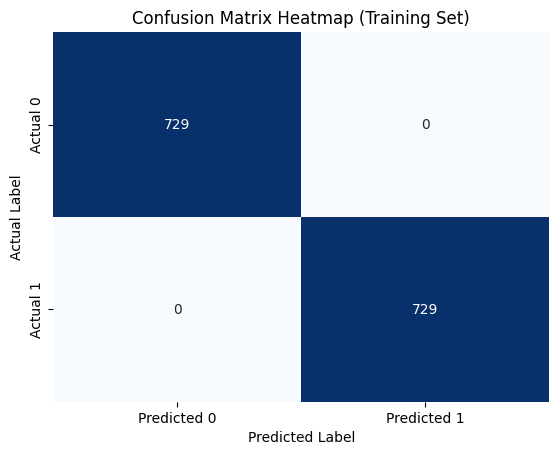

In [59]:
# 1 point for (y_train, y_train_pred)
conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Training Set)")
plt.show()

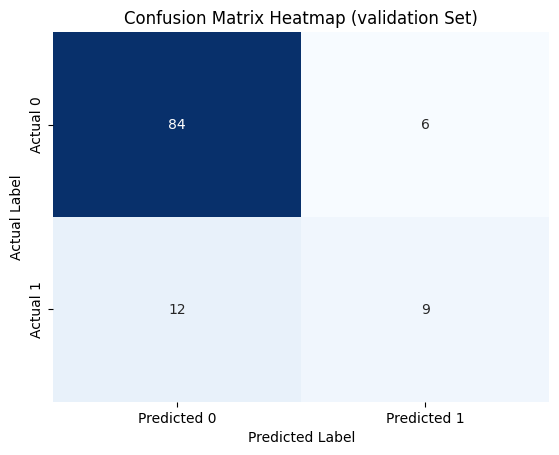

In [60]:
# 1 point for (y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (validation Set)")
plt.show()

# P9: Performance on testing data (4 points)

call the model on test data. **(P9-1: 1 point)**

In [61]:
y_pred = model.predict(X_test)

evaluate your model on the testing data using f1_score. **(P9-2: 1 point)**

In [62]:
print(f'Test accuracy are: {accuracy_score(y_test, y_pred)}')
print(f'Test recall are: {recall_score(y_test, y_pred)}')
print(f'Test f1 are: {f1_score(y_test, y_pred)} ')

Test accuracy are: 0.8545454545454545
Test recall are: 0.3125
Test f1 are: 0.38461538461538464 


What is the origin of loosing performance on the test set? Answer briefly here. **(P9-3: 1 point)**

** One of the reasons is overfitting. the model is too complex and captures noise in the training set. when this happens the model will not perform well on the test set(because it can not generalize well). also, our hyperparametr tuning finds the best fit for validation which obviously differs from the test set(they just have 100 samples) and we should expect some losing performance because of this and it's reasonable. but if the performance loss gets too much we should ask for another reason. 
hyperparameters like learning rate are more special in this model and it can cause overfitting. therefore the performance get lose**

Plot the heatmap of the confusion matrix here. **(P9-4: 1 point)**

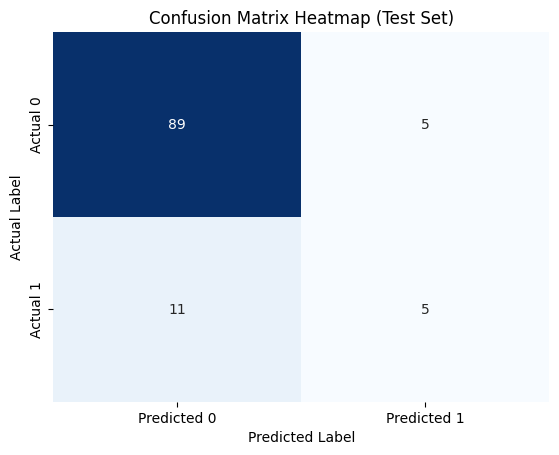

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap (Test Set)")
plt.show()